In [80]:
using ProfileView

In [1]:
using RigidBodyDynamics
using Interact

In [2]:
import RigidBodyTreeInspector

adding: /home/rdeits/.julia/v0.5/DrakeVisualizer/src/lcmtypes to the python path


In [122]:
reload("DrakeVisualizer")
reload("RigidBodyTreeInspector")

adding: /home/rdeits/.julia/v0.5/DrakeVisualizer/src/lcmtypes to the python path


INFO: Recompiling stale cache file /home/rdeits/.julia/lib/v0.5/RigidBodyTreeInspector.ji for module RigidBodyTreeInspector.


adding: /home/rdeits/.julia/v0.5/DrakeVisualizer/src/lcmtypes to the python path


In [123]:
mechanism = rand_chain_mechanism(Float64, [QuaternionFloating{Float64}; [Revolute{Float64} for i = 1:5]]...)
state = MechanismState(Float64, mechanism)

MechanismState{Float64, Float64, Float64}(…)

In [124]:
vis = DrakeVisualizer.Visualizer()[:robot1]

DrakeVisualizer.Visualizer(DrakeVisualizer.CoreVisualizer(PyLCM.LCM(PyObject <LCM object at 0x7f8f380bd150>),LazyTree: DrakeVisualizer.VisData(CoordinateTransformations.IdentityTransformation(),DrakeVisualizer.GeometryData[]),DrakeVisualizer.CommandQueue(Set{Array{Symbol,1}}(),Set{Array{Symbol,1}}(),Set{Array{Symbol,1}}()),true),Symbol[:robot1])

In [125]:
RigidBodyTreeInspector.load!(vis, RigidBodyTreeInspector.create_geometry(mechanism))

In [126]:
RigidBodyTreeInspector.draw!(vis, state)

0.0008907648110000001


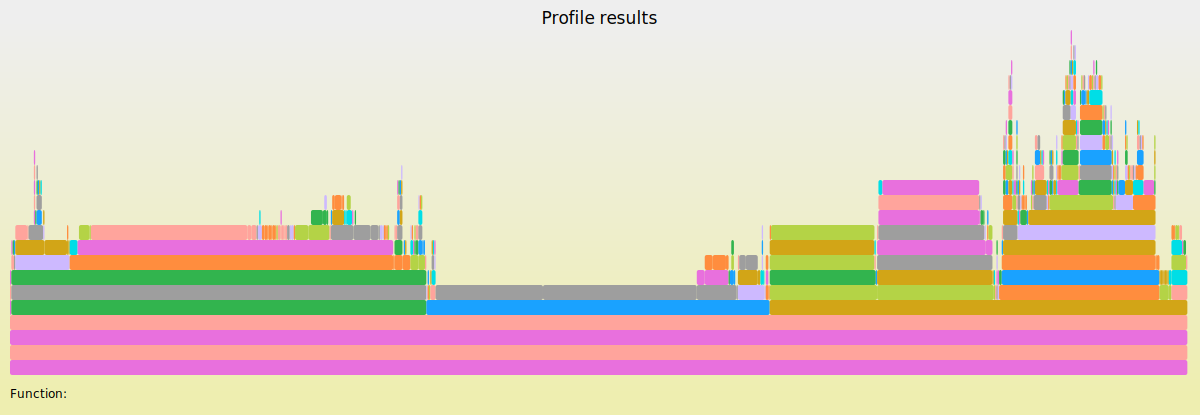

In [127]:
# We can draw the mechanism at a single state:
state = MechanismState(Float64, mechanism)
zero!(state)

vis.core.publish_immediately = false
Profile.clear()
println((@elapsed (@profile for i in 1:1000
    DrakeVisualizer.empty!(vis.core.queue)
    RigidBodyTreeInspector.draw!(vis, state)
    data = DrakeVisualizer.serialize(vis.core, vis.core.queue)
    msg = DrakeVisualizer.to_lcm(data)
end)) / 1000)
vis.core.publish_immediately = true
ProfileView.view()

In [132]:
# Or we can interactively explore the degrees of freedom of the mechanism.
# Note that the quaternion floating base joint, "joint1", has been given 
# six sliders. The first three correspond to the exponential map representation
# of its rotation, and the next three correspond to its translation. 
RigidBodyTreeInspector.inspect(mechanism; show_inertias=true, randomize_colors=true);

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(-0.12566370614359187, nactions=1),"joint1.1",-0.12566370614359187,"-0.12566370614359187",Interact.OptionDict(DataStructures.OrderedDict("-3.141592653589793"=>-3.14159,"-3.015928947446201"=>-3.01593,"-2.8902652413026093"=>-2.89027,"-2.7646015351590183"=>-2.7646,"-2.6389378290154264"=>-2.63894,"-2.5132741228718345"=>-2.51327,"-2.3876104167282426"=>-2.38761,"-2.261946710584651"=>-2.26195,"-2.1362830044410597"=>-2.13628,"-2.0106192982974673"=>-2.01062…),Dict(2.13628=>"2.1362830044410597",-3.01593=>"-3.015928947446201",-2.13628=>"-2.1362830044410597",1.88496=>"1.8849555921538756",1.75929=>"1.7592918860102842",2.63894=>"2.6389378290154264",-0.376991=>"-0.3769911184307753",0.251327=>"0.25132741228718347",-2.51327=>"-2.5132741228718345",1.25664=>"1.2566370614359172"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(-0.12566370614359187, nactions=1),"joint1.2",-0.12566370614359187,"-0.12566370614359187",Interact.OptionDict(DataStructures.OrderedDict("-3.141592653589793"=>-3.14159,"-3.015928947446201"=>-3.01593,"-2.8902652413026093"=>-2.89027,"-2.7646015351590183"=>-2.7646,"-2.6389378290154264"=>-2.63894,"-2.5132741228718345"=>-2.51327,"-2.3876104167282426"=>-2.38761,"-2.261946710584651"=>-2.26195,"-2.1362830044410597"=>-2.13628,"-2.0106192982974673"=>-2.01062…),Dict(2.13628=>"2.1362830044410597",-3.01593=>"-3.015928947446201",-2.13628=>"-2.1362830044410597",1.88496=>"1.8849555921538756",1.75929=>"1.7592918860102842",2.63894=>"2.6389378290154264",-0.376991=>"-0.3769911184307753",0.251327=>"0.25132741228718347",-2.51327=>"-2.5132741228718345",1.25664=>"1.2566370614359172"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(-0.12566370614359187, nactions=1),"joint1.3",-0.12566370614359187,"-0.12566370614359187",Interact.OptionDict(DataStructures.OrderedDict("-3.141592653589793"=>-3.14159,"-3.015928947446201"=>-3.01593,"-2.8902652413026093"=>-2.89027,"-2.7646015351590183"=>-2.7646,"-2.6389378290154264"=>-2.63894,"-2.5132741228718345"=>-2.51327,"-2.3876104167282426"=>-2.38761,"-2.261946710584651"=>-2.26195,"-2.1362830044410597"=>-2.13628,"-2.0106192982974673"=>-2.01062…),Dict(2.13628=>"2.1362830044410597",-3.01593=>"-3.015928947446201",-2.13628=>"-2.1362830044410597",1.88496=>"1.8849555921538756",1.75929=>"1.7592918860102842",2.63894=>"2.6389378290154264",-0.376991=>"-0.3769911184307753",0.251327=>"0.25132741228718347",-2.51327=>"-2.5132741228718345",1.25664=>"1.2566370614359172"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(-0.12566370614359187, nactions=1),"joint1.4",-0.12566370614359187,"-0.12566370614359187",Interact.OptionDict(DataStructures.OrderedDict("-3.141592653589793"=>-3.14159,"-3.015928947446201"=>-3.01593,"-2.8902652413026093"=>-2.89027,"-2.7646015351590183"=>-2.7646,"-2.6389378290154264"=>-2.63894,"-2.5132741228718345"=>-2.51327,"-2.3876104167282426"=>-2.38761,"-2.261946710584651"=>-2.26195,"-2.1362830044410597"=>-2.13628,"-2.0106192982974673"=>-2.01062…),Dict(2.13628=>"2.1362830044410597",-3.01593=>"-3.015928947446201",-2.13628=>"-2.1362830044410597",1.88496=>"1.8849555921538756",1.75929=>"1.7592918860102842",2.63894=>"2.6389378290154264",-0.376991=>"-0.3769911184307753",0.251327=>"0.25132741228718347",-2.51327=>"-2.5132741228718345",1.25664=>"1.2566370614359172"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(-0.12566370614359187, nactions=1),"joint1.5",-0.12566370614359187,"-0.12566370614359187",Interact.OptionDict(DataStructures.OrderedDict("-3.141592653589793"=>-3.14159,"-3.015928947446201"=>-3.01593,"-2.8902652413026093"=>-2.89027,"-2.7646015351590183"=>-2.7646,"-2.6389378290154264"=>-2.63894,"-2.5132741228718345"=>-2.51327,"-2.3876104167282426"=>-2.38761,"-2.261946710584651"=>-2.26195,"-2.1362830044410597"=>-2.13628,"-2.0106192982974673"=>-2.01062…),Dict(2.13628=>"2.1362830044410597",-3.01593=>"-3.015928947446201",-2.13628=>"-2.1362830044410597",1.88496=>"1.8849555921538756",1.75929=>"1.7592918860102842",2.63894=>"2.6389378290154264",-0.376991=>"-0.3769911184307753",0.251327=>"0.25132741228718347",-2.51327=>"-2.5132741228718345",1.25664=>"1.2566370614359172"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(-0.12566370614359187, nactions=1),"joint1.6",-0.12566370614359187,"-0.12566370614359187",Interact.OptionDict(DataStructures.OrderedDict("-3.141592653589793"=>-3.14159,"-3.015928947446201"=>-3.01593,"-2.8902652413026093"=>-2.89027,"-2.7646015351590183"=>-2.7646,"-2.6389378290154264"=>-2.63894,"-2.5132741228718345"=>-2.51327,"-2.3876104167282426"=>-2.38761,"-2.261946710584651"=>-2.26195,"-2.1362830044410597"=>-2.13628,"-2.0106192982974673"=>-2.01062…),Dict(2.13628=>"2.1362830044410597",-3.01593=>"-3.015928947446201",-2.13628=>"-2.1362830044410597",1.88496=>"1.8849555921538756",1.75929=>"1.7592918860102842",2.63894=>"2.6389378290154264",-0.376991=>"-0.3769911184307753",0.251327=>"0.25132741228718347",-2.51327=>"-2.5132741228718345",1.25664=>"1.2566370614359172"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(-0.12566370614359187, nactions=1),"joint2.1",-0.12566370614359187,"-0.12566370614359187",Interact.OptionDict(DataStructures.OrderedDict("-3.141592653589793"=>-3.14159,"-3.015928947446201"=>-3.01593,"-2.8902652413026093"=>-2.89027,"-2.7646015351590183"=>-2.7646,"-2.6389378290154264"=>-2.63894,"-2.5132741228718345"=>-2.51327,"-2.3876104167282426"=>-2.38761,"-2.261946710584651"=>-2.26195,"-2.1362830044410597"=>-2.13628,"-2.0106192982974673"=>-2.01062…),Dict(2.13628=>"2.1362830044410597",-3.01593=>"-3.015928947446201",-2.13628=>"-2.1362830044410597",1.88496=>"1.8849555921538756",1.75929=>"1.7592918860102842",2.63894=>"2.6389378290154264",-0.376991=>"-0.3769911184307753",0.251327=>"0.25132741228718347",-2.51327=>"-2.5132741228718345",1.25664=>"1.2566370614359172"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(-0.12566370614359187, nactions=1),"joint3.1",-0.12566370614359187,"-0.12566370614359187",Interact.OptionDict(DataStructures.OrderedDict("-3.141592653589793"=>-3.14159,"-3.015928947446201"=>-3.01593,"-2.8902652413026093"=>-2.89027,"-2.7646015351590183"=>-2.7646,"-2.6389378290154264"=>-2.63894,"-2.5132741228718345"=>-2.51327,"-2.3876104167282426"=>-2.38761,"-2.261946710584651"=>-2.26195,"-2.1362830044410597"=>-2.13628,"-2.0106192982974673"=>-2.01062…),Dict(2.13628=>"2.1362830044410597",-3.01593=>"-3.015928947446201",-2.13628=>"-2.1362830044410597",1.88496=>"1.8849555921538756",1.75929=>"1.7592918860102842",2.63894=>"2.6389378290154264",-0.376991=>"-0.3769911184307753",0.251327=>"0.25132741228718347",-2.51327=>"-2.5132741228718345",1.25664=>"1.2566370614359172"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(-0.12566370614359187, nactions=1),"joint4.1",-0.12566370614359187,"-0.12566370614359187",Interact.OptionDict(DataStructures.OrderedDict("-3.141592653589793"=>-3.14159,"-3.015928947446201"=>-3.01593,"-2.8902652413026093"=>-2.89027,"-2.7646015351590183"=>-2.7646,"-2.6389378290154264"=>-2.63894,"-2.5132741228718345"=>-2.51327,"-2.3876104167282426"=>-2.38761,"-2.261946710584651"=>-2.26195,"-2.1362830044410597"=>-2.13628,"-2.0106192982974673"=>-2.01062…),Dict(2.13628=>"2.1362830044410597",-3.01593=>"-3.015928947446201",-2.13628=>"-2.1362830044410597",1.88496=>"1.8849555921538756",1.75929=>"1.7592918860102842",2.63894=>"2.6389378290154264",-0.376991=>"-0.3769911184307753",0.251327=>"0.25132741228718347",-2.51327=>"-2.5132741228718345",1.25664=>"1.2566370614359172"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(-0.12566370614359187, nactions=1),"joint5.1",-0.12566370614359187,"-0.12566370614359187",Interact.OptionDict(DataStructures.OrderedDict("-3.141592653589793"=>-3.14159,"-3.015928947446201"=>-3.01593,"-2.8902652413026093"=>-2.89027,"-2.7646015351590183"=>-2.7646,"-2.6389378290154264"=>-2.63894,"-2.5132741228718345"=>-2.51327,"-2.3876104167282426"=>-2.38761,"-2.261946710584651"=>-2.26195,"-2.1362830044410597"=>-2.13628,"-2.0106192982974673"=>-2.01062…),Dict(2.13628=>"2.1362830044410597",-3.01593=>"-3.015928947446201",-2.13628=>"-2.1362830044410597",1.88496=>"1.8849555921538756",1.75929=>"1.7592918860102842",2.63894=>"2.6389378290154264",-0.376991=>"-0.3769911184307753",0.251327=>"0.25132741228718347",-2.51327=>"-2.5132741228718345",1.25664=>"1.2566370614359172"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(-0.12566370614359187, nactions=1),"joint6.1",-0.12566370614359187,"-0.12566370614359187",Interact.OptionDict(DataStructures.OrderedDict("-3.141592653589793"=>-3.14159,"-3.015928947446201"=>-3.01593,"-2.8902652413026093"=>-2.89027,"-2.7646015351590183"=>-2.7646,"-2.6389378290154264"=>-2.63894,"-2.5132741228718345"=>-2.51327,"-2.3876104167282426"=>-2.38761,"-2.261946710584651"=>-2.26195,"-2.1362830044410597"=>-2.13628,"-2.0106192982974673"=>-2.01062…),Dict(2.13628=>"2.1362830044410597",-3.01593=>"-3.015928947446201",-2.13628=>"-2.1362830044410597",1.88496=>"1.8849555921538756",1.75929=>"1.7592918860102842",2.63894=>"2.6389378290154264",-0.376991=>"-0.3769911184307753",0.251327=>"0.25132741228718347",-2.51327=>"-2.5132741228718345",1.25664=>"1.2566370614359172"…)),Any[],Any[],true,"horizontal")

In [134]:
# We can also animate the mechanism, given a time sequence of states.
# States will be linearly interpolated between the knot points.
times = collect(linspace(0, 10, 3))
configurations = Vector{Vector{Float64}}(length(times))
for i = 1:length(times)
    rand_configuration!(state)
    configurations[i] = copy(configuration_vector(state))
end
RigidBodyTreeInspector.load!(vis, RigidBodyTreeInspector.create_geometry(mechanism))
RigidBodyTreeInspector.animate(vis, mechanism, times, configurations; fps = 60., realtimerate = 1.)

In [8]:
# We can simulate a mechanism from an initial state. We'll use a mechanism
# without a QuaternionFloating joint so that it doesn't just fall straight down.
mechanism = rand_chain_mechanism(Float64, [Revolute{Float64} for i = 1:10]...)
vis = Visualizer()[:robot2]
RigidBodyTreeInspector.load!(vis, mechanism)
state = MechanismState(Float64, mechanism)
zero!(state)
draw(vis, state)
times, configurations, velocities = simulate(state, 10.);

In [9]:
# And we can animate the result in realtime
animate(vis, mechanism, times, configurations)

In [10]:
# We can also inspect individual frames from the simulation
@manipulate for i in 1:length(times)
    RigidBodyDynamics.set_configuration!(state, configurations[i])
    RigidBodyDynamics.set_velocity!(state, velocities[i])
    draw(vis, state)
    times[i]
end

Interact.Slider{Int64}(Signal{Int64}(50001, nactions=0),"i",50001,1:100002,"d",true)

5.000000000001686

In [11]:
# close the viewer
kill(proc)

0